Creating new data for Mnist datasets is the objective of this notebook. This is also a tutorial on GAN which is more and more use for generative models.

## 1. GAN description ##

I will not too much describe it here as there are many really good websites for, all based on 2014 paper.

Basically two neural networks are competiting: a generator creates a picture, and the discriminator is trying to detect it as fake or not. We are injecting in the discrimator real picture et generated picture. After a while, generator starts generating pictures close to original dataset.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./gan.png",width=700, height=450)

As this my first contact with GAN, Ì will not try to produce exotic pictures, but will only use the boring Mnist dataset and apply general principles of GAN

## 2. Do it! ##

Here are the general steps I understood : 
    1. Generate few pictures with generator. This is gonna be pure random at first
    2. Get the generated pictures and add same numbers from training set. From the created batch of picture, train the generator to discern fake from real picture.
    3. After few steps of training, Discrimator is fixed and we create new picture in the generator, and we submit them to the discriminator. We optimize then the generator to make its pictures as real as possible.
    4. Repeat last 3 steps, until created pictures are good quality (i.e state of equilibrium where Generator produces picture that discriminator can not discern from real picture, while discriminator one time over two find a fake picture).

Before building the model, few interesting words from Siraj Ravel github and DCGAN paper:

* Batch normalization is a must in both networks.
* Fully hidden connected layers are not a good idea.
* Avoid pooling, simply stride your convolutions!
* Use ReLU activation in generator for all layers except for the output, which uses tanh. 
* Use LeakyReLU activation in the discriminator for all layers.


Minimax theorem that started the game theory states that for two players in a zero-sum game the minimax solution is the same as the Nash equilibrium.

In simpler terms, when two players (D and G) are competing against each other (zero-sum game), and both play optimally assuming that their opponent is optimally (minimax strategy), the outcome is predetermined and none of the players can change it (Nash equilibrium).
So, for our networks, it means that if we train them long enough, the Generator will learn how to sample from true “distribution,” meaning that it will start generating real life-like images, and the Discriminator will not be able to tell fake ones from genuine ones.

### 2.1 Generator ###

Generator is basically a "de"-convnet network that is outputting a picture with same dimensioins from the dataset. So let's first import the mnist data.'

In [143]:
#import tensorflow as tf
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.backend import resize_images
from keras.initializers import RandomNormal

from keras.optimizers import Adam,RMSprop


#mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()

# no need the labels, so we will gather all examples x.
# Return a numpy array of shape (M, 28, 28)
num_train, num_test = x_train.shape[0], x_test.shape[0]
M = num_train + num_test
x_all = np.zeros((M, 28, 28))
x_all[:num_train, :, :] = x_train
x_all[num_train:, :, :] = x_test

So we have the data, what architecture for the Generator? For about a year after the first paper, training GANs seems difficult. In 2016 Radford et al. published the paper titled “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks” describing the model that subsequently became famous as DCGAN. In the paper, the DCGAN architecture looks like this:

In [3]:
Image(url= "./gen_architecture.png",width=700, height=450)

MNIST dataset is composed of monochrome 28x28 pixel images, so the desired shape for our input layer is [batch_size, 28, 28, 1]. This will flatten the picture in a 1D array.

Ok, so my understanding: The generated vector z has real values from -1 to 1 and follows the Gaussian distribution then :
1. Input layer. Regarding z (100,1) : We should reshape it, but seem sybilin to me. (batch_size, 100,1,1) ? 
2. First step: Project and reshape: convert our input layer to 4x4x1024.
3. 1st "deconvnet layer":the inverse of convolution, called transposed convolution, 512 filters of shape 5,5, stride=2  then relu activation. To calculate output shape of deconv layer: With padding=Same: H = H1 x stride if padding=Valid
H = (H1-1) x stride + HF (H = output size, H1 = input size, HF = height of filter)
4. 2nd "deconvnet layer: 256 filters 5x5
5. 3rd deconvnet layer: 128 filters 5,5
6. 4th deconvnet layer: 1 filters 5,5 # woulb 3 filters for RGB picture

As the output we want a 28x28 pictures. Meaning we have to change stride compares to original papers. If we keep using stride of 2, we will end up with 64x64 pictures. What we could try at first is just using a stride of 1 on first layer, in order to output 32x32 picture which is close to 28x28.

In [148]:
def generator():
    filter_size=[1024,512,256,128,1]
    weight_init = RandomNormal(mean=0.0, stddev=0.02) # as suggested in paper
    model = Sequential()
    
    model.add(Dense(input_dim=100, output_dim=filter_size[0]*4*4,kernel_initializer=weight_init)) # out =dedim x dim x
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Reshape((4, 4, 1024)))  # here shape is (batch_size, 4, 4, 1024)

    model.add(Conv2DTranspose(filters=filter_size[1], kernel_size=(5, 5), strides=(1,1), padding='same',kernel_initializer=weight_init))
    # changed from 2,2 to make sure that picture dimension as output will be close to 28x28
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9)) #conv1 output is shape (batch_size, 4, 4, 512)


    model.add(Conv2DTranspose(filters=filter_size[2], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9)) #conv2 output is shape (batch_size, 8, 8, 256)

    model.add(Conv2DTranspose(filters=filter_size[3], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    # changed from 2,2 to make sure that picture dimension as output will be close to 28x28
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9)) #conv1 output is shape (batch_size, 16, 16, 128)

    model.add(Conv2DTranspose(filters=filter_size[4], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    # changed from 2,2 to make sure that picture dimension as output will be close to 28x28
    model.add(Activation('tanh'))
   # model.add(BatchNormalization(momentum=0.9)) #conv4 output is shape (batch_size, 32, 32, 1)

    return model
#RandomNormal(mean=0.0, stddev=0.05, seed=None)

ok now let's try to display a picture given a random Z as input, for a batch_size of 3:

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, kernel_initializer=<keras.ini..., units=16384)`
  


3/3 [==============================] - 4s 1s/step
(3, 32, 32, 1)


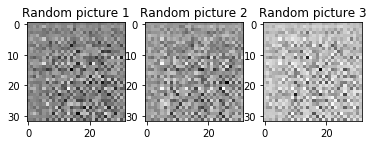

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt

BATCH_SIZE = 3

Z = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
gen = generator()
gen.compile(loss='binary_crossentropy', optimizer="SGD")
generated_images = gen.predict(Z, verbose=1)

print(generated_images.shape)
plt.subplot(1, 3, 1)
plt.imshow(generated_images[0].reshape(32, 32), cmap=plt.cm.Greys)
plt.title('Random picture 1')

plt.subplot(1, 3, 2)
plt.imshow(generated_images[1].reshape(32, 32), cmap=plt.cm.Greys)
plt.title('Random picture 2')
    
plt.subplot(1, 3, 3)
plt.imshow(generated_images[2].reshape(32, 32), cmap=plt.cm.Greys)
plt.title('Random picture 3')

plt.show() 

Cool, now we have a random picture generator, taking a [batch_size,100] array as input. There is a nice article about upsampling a picture, nice to read: https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0

### 2.2 Discriminator ###

Basically, this is the opposite of our generator. From a 32x32 picture, we will use the convnet to output a number between 0 and 1. 

In [6]:
Image(url= "./discriminator.png",width=700, height=450)

As a reminder, the ouput size of a convolutional layer is $\frac{n+2p-f}{s}+1 $ (n= input shape, p = padding, s = stride, f= filter size). 
Padding shape is:
* "Valid" : n-f+1
* "Same" : $p=\frac{f-1}{2}$ ; n + 2p -f +1

There is no common rules regarding, the filter size, just a 2^n size. If I keep same kernel size as the generator, I will end up with 2x2x1024 as output of the last conv layer. This is maybe not good, but let's try.

In [151]:
def discriminator():
    filter_size=[128,256,512,1024]
    weight_init = RandomNormal(mean=0.0, stddev=0.02) # as suggested in paper
    
    in_shape = (32, 32,1)
    model = Sequential()
    
    model.add(Conv2D(filters=filter_size[0], kernel_size=(5, 5), strides=(2,2), padding='same',input_shape=in_shape,kernel_initializer=weight_init))
    # padding will be : p = (f-1)/2 = 2 conv_1 output size is 32x 32 :32 + 2*2 - 5 +1 = 32
    model.add(LeakyReLU(alpha=0.01))
    #model.add(BatchNormalization(momentum=0.9))  #paper does not recommand to add batchnorm to input layer
    # out shape = > 32+ 2*2 - 5/2 = 15.5 (take the round ) => 15 + 1 => ouput size 16x16x 128
    
    
    model.add(Conv2D(filters=filter_size[1], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9)) 
    # padding: p =2, out shape => 16 +4 -5 /2 = 7 => 7+1 => output size is 8x8x256
    
    model.add(Conv2D(filters=filter_size[2], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9)) 
    # padding: p =2, out shape => 8 +4 -5 /2 = 3.5 => 3+1 => output size is 4x4x512
    
    model.add(Conv2D(filters=filter_size[3], kernel_size=(5, 5), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9)) 
    # padding: p =2, out shape => 4 +4 -5 /2 = 1.5 => 1+1 => output size is 2x2x1024

    #Before we connect the layer, however, we'll flatten our feature map (conv_4) to shape [batch_size, features],
    #so that our tensor has only two dimensions:
    model.add(Flatten()) # output is 4096
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model


Let's try with a random 32x32 picture:

In [152]:
in1 = np.random.uniform(-1.0,1.0,[1, 32,32])
random_picture = np.reshape(in1, (1, 32, 32, -1))

discri = discriminator()
discri.compile(loss='binary_crossentropy',optimizer='adam') 
return_label = discri.predict(random_picture, verbose=1)
print(return_label)

1/1 [==============================] - 3s 3s/step
[[0.49755064]]


Okay seems, we correctly generate a binary prediction based on a 32x32 input.

### 2.3 Train the model ###

Now, we enter the real GAN mechanism. As a reminder we currently have a generator and a disriminator. How to handle the complete GAN process? Here are the main steps:
1. Generate a batch of fake images thanks to our Generator
2. Train the discriminator mixing the batch of fake image + a same number of real image. We also add the label 0=fake, 1=real. Optimize the weight of Discriminator network.
3. Generate picture with the generator, infere them in the discriminator network and improve the genrator network.


#### 2.3.1 Generate batch of images ####

As a example, here is how we generate 64 images:

In [9]:
batch_size = 64

Z = np.random.uniform(-1, 1, (batch_size, 100))
gen = generator()
gen.compile(loss='binary_crossentropy', optimizer="adam")
generated_images = gen.predict(Z, verbose=1)

print(generated_images.shape)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=16384)`
  """


64/64 [==============================] - 2s 27ms/step
(64, 32, 32, 1)


#### 2.3.2 Train the discriminator ####

First, we are going to train the discriminator:
* when receiving real images, the discriminator should learn to compute high values (near 1), meaning that it is confident the input images are real
* when receiving fake images, it should compute low values (near 0), meaning it is confident the input images are not real


Prepare the Mnist dataset to feed the batch:

In [88]:
def data_tensor(numpy_data):
    '''
    numpy_data: (M, 28, 28), values in range [0, 255]
    returns: tensor of images shaped [M, 32, 32, 1], with values in range [-1, 1]
    '''
    # resize images to 32x32
    npad = ((0, 0), (2, 2), (2, 2))
    X= np.pad(numpy_data,npad, 'constant', constant_values=(0, 0))
    
    X = np.expand_dims(X, axis=3) # add a dimension for number of chanel, here gray images, so only one chanel of 255 possibilities

    # The data is currently in a range [0, 255].
    # Transform data to have a range [-1, 1].
    # We do this to match the range of tanh, the activation on the generator's output layer.
    X = X / 128.
    X = X - 1.
    return X

#### 2.3.3 Combined model ####

To train the generator, we need to know the discriminator loss, so let's build a combined model which is just the genrator and then the denominator

In [134]:
def stacked_model(g, d):
    model = Sequential()
    model.add(g)
    d.trainable = False
    model.add(d)
    return model

Notice that we’re setting the discriminator’s training attribute to False before building the model. This means that for this model we will not be updating the weights of the discriminator during backpropagation. We will freeze these weights and only move the generator weights with the stack. The discriminator will be trained separately. Let's compile the models with the correct optimizer:

In [156]:
gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
disc_optimizer = Adam(lr=0.0002, beta_1=0.5)
#disc_optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-10)
gen = generator()
discri = discriminator()

discri.compile(loss='binary_crossentropy',optimizer=disc_optimizer,metrics=['accuracy'])
gen.compile(loss='binary_crossentropy', optimizer=gen_optimizer)



combined = stacked_model(gen,discri)
combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, kernel_initializer=<keras.ini..., units=16384)`
  


Notice that beta_1 = 0.5. This is a recommendation from the original DCGAN paper that we’ve carried forward and also had success with. A learning rate of 0.0002 is a good place to start, also recommended by DCGAN paper.

In [101]:
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_45 (Sequential)   (None, 32, 32, 1)         18931205  
_________________________________________________________________
sequential_46 (Sequential)   (None, 1)                 17220097  
Total params: 36,151,302
Trainable params: 18,896,643
Non-trainable params: 17,254,659
_________________________________________________________________


Again, the trainable params is not as big as the total params, due to the action to freeze the discriminator weights in combined model.

#### 2.3.4 Train the model ####

Just to simply understand. Let's train it first on only one batch (X) of 64 real picture and 64 fake pictures and their corresponding labels.

In [157]:
batch_size = 64

# creating 64 fake images and 64 real images
noise = np.random.normal(0, 1, (64, 100))
fake_images = gen.predict(noise)
fake_labels = np.zeros((64, 1))

image_batch = x_all[0:64]
real_images=data_tensor(image_batch)

real_labels = np.ones((64, 1))

print(real_images.shape)

(64, 32, 32, 1)


In [103]:
# Train the discriminator (real classified as ones and generated as zeros)
d_loss_real = discri.train_on_batch(real_images, real_labels)
d_loss_fake = discri.train_on_batch(fake_images, fake_labels)

/usr/local/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator model has updated weight, thanks to real images and fake images. The model is theoritically better at discerning fake and real images.

In [111]:
d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


[3.4712086 0.25     ]
0.14933929


In [112]:
noise = np.random.normal(0, 1, (64, 100))

# Train the generator with fake images, pretending this is real ones.
g_loss = combined.train_on_batch(noise, np.ones((64, 1)))

# Plot the progress
print("[D loss: %f, acc.: %.2f%%] [G loss: %f]" %( d_loss[0], 100 * d_loss[1], g_loss))


[D loss: 3.471209, acc.: 25.00%] [G loss: 0.000945]


#### 2.3.5 A word about theory ####

The discriminator’s loss function is the cross entropy loss function. To understand this, let’s suppose we’re doing some binary classification with some trainable function D that we wish to optimize, where D
D indicates the estimated probability of some data point $x_{i}$ being in the first class. To get the predicted probability of being in the second class, we just do 1-D($x_{i}$).

The cross entropy between two distributions, which we’ll call p and q, is defined as:

$H(p,q) = - \sum(p_{i} log(q_{i})$

To apply this loss function to the current binary classification task, we define the true distribution as $P[y_{i}=0]=1$ if $y_{i}=0$ and $P[y_{i}=1]=1$ if $y_{i}=1$

Thus, for one data point x1 and its label, we get the following loss function:

$H(x1,y1) = -y1.log(D(x1)-(1-y1)log(1-D(x1))$

Let’s look at the above function. Notice that only one of the two terms is going to be zero, depending on the value of y1 , which makes sense since it’s defining a distribution which is either [0,1] or [1,0].


Have a look here https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/

#### 2.3.6 Complete training ####

Let's replace everything in complete training. We will use batch of 64 images. Also introduce a function to save the generated pictures:

In [154]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.close()

In [155]:
batch_size = 128
epochs = 50

num_examples = x_all.shape[0] # around 70k examples.
num_batches = int(num_examples / float(batch_size)) # around 1093 batches
half_batch = int(batch_size / 2) # 32 pictures

for epoch in range(epochs + 1):
    for batch in range(num_batches):
    # creating the real and fake picture for this batch
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = gen.predict(noise)
        fake_labels = np.zeros((half_batch, 1))

        image_batch = x_all[batch*half_batch:batch*half_batch+half_batch]
        real_images=data_tensor(image_batch)

        real_labels = np.ones((half_batch, 1))
        
     # train the discriminator on both real and fake images
        d_loss_real = discri.train_on_batch(real_images, real_labels)
        d_loss_fake = discri.train_on_batch(fake_images, fake_labels)
    
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        
    # train the generator
        noise = np.random.normal(0, 1, (half_batch, 100))
        # Train the generator with fake images, pretending this is real ones.
        g_loss = combined.train_on_batch(noise, np.ones((half_batch, 1)))
            
        
        print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))
        if batch % 50 == 0:
            save_imgs(gen, epoch, batch)
        

/usr/local/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/546 [D loss: 3.701529, acc.: 35.16%] [G loss: 1.796620]
Epoch 0 Batch 1/546 [D loss: 0.309367, acc.: 85.16%] [G loss: 5.773452]
Epoch 0 Batch 2/546 [D loss: 0.027594, acc.: 100.00%] [G loss: 6.901357]
Epoch 0 Batch 3/546 [D loss: 0.008008, acc.: 100.00%] [G loss: 6.646492]
Epoch 0 Batch 4/546 [D loss: 0.063209, acc.: 97.66%] [G loss: 7.772598]
Epoch 0 Batch 5/546 [D loss: 0.000700, acc.: 100.00%] [G loss: 10.238914]
Epoch 0 Batch 6/546 [D loss: 0.003085, acc.: 100.00%] [G loss: 9.356950]
Epoch 0 Batch 7/546 [D loss: 0.009628, acc.: 99.22%] [G loss: 8.286095]
Epoch 0 Batch 8/546 [D loss: 0.002775, acc.: 100.00%] [G loss: 7.172940]
Epoch 0 Batch 9/546 [D loss: 0.003542, acc.: 100.00%] [G loss: 6.990102]
Epoch 0 Batch 10/546 [D loss: 0.010367, acc.: 100.00%] [G loss: 8.128311]
Epoch 0 Batch 11/546 [D loss: 0.003518, acc.: 100.00%] [G loss: 8.311946]
Epoch 0 Batch 12/546 [D loss: 0.002743, acc.: 100.00%] [G loss: 7.950078]
Epoch 0 Batch 13/546 [D loss: 0.005713, acc.: 100.0

Epoch 0 Batch 111/546 [D loss: 0.000123, acc.: 100.00%] [G loss: 11.985822]
Epoch 0 Batch 112/546 [D loss: 0.000374, acc.: 100.00%] [G loss: 10.638206]
Epoch 0 Batch 113/546 [D loss: 0.001454, acc.: 100.00%] [G loss: 13.435026]
Epoch 0 Batch 114/546 [D loss: 0.000609, acc.: 100.00%] [G loss: 13.183672]
Epoch 0 Batch 115/546 [D loss: 0.000711, acc.: 100.00%] [G loss: 10.667036]
Epoch 0 Batch 116/546 [D loss: 0.000468, acc.: 100.00%] [G loss: 9.414034]
Epoch 0 Batch 117/546 [D loss: 0.011453, acc.: 99.22%] [G loss: 15.671572]
Epoch 0 Batch 118/546 [D loss: 9.992313, acc.: 1.56%] [G loss: 0.065303]
Epoch 0 Batch 119/546 [D loss: 7.420432, acc.: 51.56%] [G loss: 1.611216]
Epoch 0 Batch 120/546 [D loss: 6.320627, acc.: 58.59%] [G loss: 2.970214]
Epoch 0 Batch 121/546 [D loss: 6.535312, acc.: 57.03%] [G loss: 4.810687]
Epoch 0 Batch 122/546 [D loss: 3.622310, acc.: 73.44%] [G loss: 15.510130]
Epoch 0 Batch 123/546 [D loss: 6.727485, acc.: 50.00%] [G loss: 16.109451]
Epoch 0 Batch 124/546 [D 

Epoch 0 Batch 221/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 222/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 223/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 224/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 225/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 226/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 227/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 228/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 229/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 230/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 231/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 232/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 233/546 [D loss: 7.971192, acc.: 50.00%] [G loss: 0.000000]
Epoch 0 Batch 234/546 [D loss: 7.97119

KeyboardInterrupt: 

After several epochs, this is how the generated images are evolving:

In [160]:
Image(url= "./animation.gif",width=700, height=450)

Here is the last pictures generated after 14 epochs:

In [162]:
Image(url= "./mnist_14_0.png",width=700, height=450)

Not too bad. Surely can be improved with parameters tuning and mlaybe train longer.